In [1]:
import numpy as np
import tensorflow as tf
#import tensorflow_quantum as tfq
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2DTranspose, Conv2D, Layer, Reshape, Dropout, LeakyReLU, BatchNormalization, Flatten
from keras.initializers import RandomNormal
from sklearn import datasets

#import cirq
import sympy

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
#from cirq.contrib.svg import SVGCircuit

from IPython import display
import glob
from PIL import Image
from tqdm import tqdm
import datetime

# mlflow tools
import mlflow
from mlflow.tracking import MlflowClient



c:\Users\Ludovico\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#%load_ext tensorboard

## Parameters

In [3]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/GAN/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(log_dir)

#gen_init_layer_size = (7, 7, 256) # generator input size
gen_init_layer_size = (2, 2, 16)
disc_input_shape = (8, 8, 1) # discriminator input shape
z_dim = 10  # random noise dimension

buffer_size = 60000
batch_size = 256

### Dataset

In [4]:
# Load the digits dataset
digits = datasets.load_digits()

x_train = digits.data
y_train = digits.target

x_train = x_train.reshape(len(x_train), 8, 8)
x_train.shape

(1797, 8, 8)

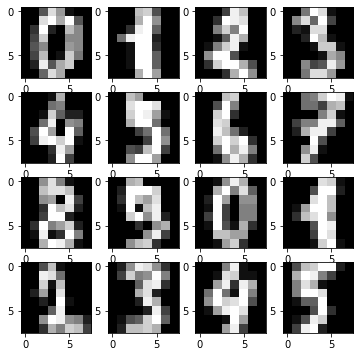

In [5]:
plt.figure(figsize=(6, 6))

for i, image in enumerate(digits.images[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [6]:
x = np.array([t for t, l in zip(x_train, y_train) if l in (0, 1)])

x.shape, x.max()

((360, 8, 8), 16.0)

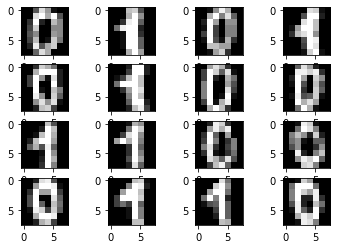

In [7]:
for i, image in enumerate(x[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break 

In [8]:
x = x.reshape(x.shape[0], 8, 8, 1).astype('float32')
x = (x - 8) / 8
#x

In [9]:
x_train = x_train.reshape(x_train.shape[0], 8, 8, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5
x_train.shape

(1797, 8, 8, 1)

In [10]:
train_dataset_digits = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:10]).shuffle(buffer_size).batch(batch_size

In [11]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

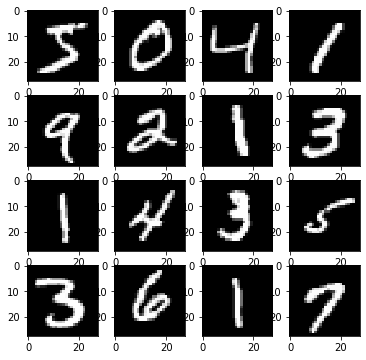

In [12]:
plt.figure(figsize=(6, 6))

for i, image in enumerate(train_images[:16], 1):
    try:
        plt.subplot(4, 4, i)
        plt.imshow(image, cmap='gray')
    except ValueError:
        break   

In [13]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # normalize the images to [-1, 1]
#x_train = train_images[30000:]
train_images.shape

(60000, 28, 28, 1)

In [14]:
# batch and shuffle the data
train_dataset_mnist = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images[:10]).shuffle(buffer_size).batch(batch_size)

#for element in train_dataset_mnist:
#   print(element)

### Classical GAN

In [15]:
'''
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x)

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')
'''

"\nclass generator():\n\n    def __init__(self, gen_init_layer_size, z_dim):\n\n        super(generator, self).__init__()\n        self.gen_init_layer_size = gen_init_layer_size\n        self.z_dim = z_dim\n        self.gen_weight = RandomNormal(mean=0., stddev=1.0)\n        self.input = Input(shape=self.z_dim)\n        \n\n    def build_gen(self):\n\n        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, \n                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        \n        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)\n        x = BatchNormalization()(x)\n        x = LeakyReLU()(x)\n        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)\n        x = BatchNorm

In [16]:
'''
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  
'''

"\nclass discriminator():\n    def __init__(self, disc_input_shape):\n        \n        super(discriminator, self).__init__() \n        self.disc_input_shape = disc_input_shape\n        self.disc_weight = RandomNormal(mean = 0., stddev = 1.) \n        self.input = Input(shape=self.disc_input_shape)    \n              \n\n    def build_disc(self):\n        \n        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)\n        x = LeakyReLU()(x)\n        x = Dropout(0.3)(x)\n        x = Flatten()(x)\n        x = Dense(1, activation='sigmoid', kernel_initializer = self.disc_weight)(x)\n\n        output = x\n\n        return Model(self.input, output, name = 'Discriminator_Network')  \n"

In [17]:
class generator():

    def __init__(self, gen_init_layer_size, z_dim):

        super(generator, self).__init__()
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.gen_weight = RandomNormal(mean=0., stddev=1.0)
        self.input = Input(shape=self.z_dim)
        

    def build_gen(self):

        x = Dense(np.prod(self.gen_init_layer_size), use_bias = False, 
                          input_shape=(self.z_dim,), kernel_initializer = self.gen_weight)(self.input)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Reshape((self.gen_init_layer_size[0], self.gen_init_layer_size[1], self.gen_init_layer_size[2]))(x)        
        x = Conv2DTranspose(128, (5, 5), strides = (1, 1), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(64, (5, 5), strides = (2, 2), padding = 'same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation='tanh')(x) 

        output = x
            
        return Model(self.input, output, name = 'Generator_Network')

Model: "Generator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                640       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 128)        51200     
 nspose)                                         

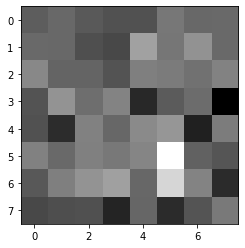

In [18]:
# Defining generator network
z_noise = tf.random.normal([6, z_dim])
gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
gen_net = gen.build_gen()
generated_image = gen_net(z_noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
#generated_image
gen_net.summary()

In [19]:
#generated_image

In [20]:
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# def gen_loss(fake_out):
#         return loss(tf.ones_like(fake_out), fake_out)

# gen_opt = tf.keras.optimizers.Adam(0.3)

In [21]:
# with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
#     #image = tf.expand_dims(image, axis = 0)
#     generated_images = gen_net(z_noise, training=True)
#     #print('gen img', generated_images.shape)

#     #real_out = disc_net(image, training = True)
    
#     fake_out = disc_net(generated_images, training = True)
#     #print('fake_out: ', fake_out)

#     gl = gen_loss(fake_out)
#     #print('gen loss: ', gl)
#     #print('pgg w: ', gen_net.trainable_variables)
#     #disc_loss = disc_loss(real_out, fake_out)

# gradients_of_generator = gen_tape.gradient(gl, gen_net.trainable_variables)
# print('Gradient gen: ', gradients_of_generator)

# gen_opt.apply_gradients(zip(gradients_of_generator, gen_net.trainable_variables))

In [22]:
#gen_net.trainable_variables

In [23]:
class discriminator():
    def __init__(self, disc_input_shape):
        
        super(discriminator, self).__init__() 
        self.disc_input_shape = disc_input_shape
        #self.disc_weight = RandomNormal(mean = 0., stddev = 1.) 
        self.input = Input(shape=self.disc_input_shape)    
              

    def build_disc(self):
        
        x = Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = self.disc_input_shape)(self.input)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Conv2D(128, (5, 5), strides = (2, 2), padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Dropout(0.3)(x)
        x = Flatten()(x)
        x = Dense(1)(x)#, kernel_initializer = self.disc_weight)

        output = x

        return Model(self.input, output, name = 'Discriminator_Network')  

In [24]:
# Defining discriminator network
disc = discriminator(disc_input_shape = disc_input_shape)
disc_net = disc.build_disc()

a = x_train[0]
a = tf.expand_dims(a, axis = 0)
print(disc_net(a))

disc_net.summary()

tf.Tensor([[0.02217667]], shape=(1, 1), dtype=float32)
Model: "Discriminator_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 128)         0         
                                                        

In [25]:
#disc_net.trainable_weights

In [26]:
class Trainer():

    def __init__(self, x_train, gen_net, disc_net, gen_init_layer_size, z_dim, disc_input_shape, batch_size, writer, log_dir, logging = True):
        super(Trainer, self).__init__()
        self.x_train = x_train
        self.gen_init_layer_size = gen_init_layer_size
        self.z_dim = z_dim
        self.disc_input_shape = disc_input_shape
        self.gen_opt = tf.keras.optimizers.Adam(1e-4)
        self.disc_opt = tf.keras.optimizers.Adam(1e-4) 
        self.batch_size = batch_size      
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits = False) 
        self.gen_net = gen_net 
        self.disc_net = disc_net  
        self.writer = writer  
        self.logging= logging  
        self.log_dir = log_dir

        self.g_loss = []
        self.d_loss = []
    
    def gen_loss(self, fake_out):
        return self.loss(tf.ones_like(fake_out), fake_out)


    def disc_loss(self, img, fake_out):

        real_loss = self.loss(tf.ones_like(img), img)
        fake_loss = self.loss(tf.zeros_like(fake_out), fake_out)

        total_loss = real_loss + fake_loss
        return total_loss   


    def generate_and_save_images(self, model, epoch, test_input):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        predictions = model(test_input, training=False)
        #print(predictions.shape)

        plt.figure(figsize=(8, 8))

        for i, image in enumerate(predictions, 1):
            try:
                plt.subplot(4, 4, i)
                plt.imshow(image[:, :, 0], cmap='gray')
            except ValueError:
                break       
        
        plt.savefig(self.log_dir + 'image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()


    def train_step(self, image):

        noise = tf.random.normal([self.batch_size, self.z_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #image = tf.expand_dims(image, axis = 0)
            generated_images = self.gen_net(noise, training=True)
            #print('gen img', generated_images.shape)

            real_out = self.disc_net(image, training = True)
            fake_out = self.disc_net(generated_images, training = True)
            #print('fake_out: ', fake_out)

            gen_loss = self.gen_loss(fake_out)
            #print('gen loss: ', gen_loss)
            disc_loss = self.disc_loss(real_out, fake_out)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen_net.trainable_variables)
        #print('Gradient gen: ', gradients_of_generator)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc_net.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_of_generator, self.gen_net.trainable_variables))
        self.disc_opt.apply_gradients(zip(gradients_of_discriminator, self.disc_net.trainable_variables))
            
        return gen_loss, disc_loss


    def learn(self, epochs):

        #print(len(self.x_train))

        #with tqdm(range(epochs), desc="GAN", unit="epochs") as tepochs:

        for epoch in range(epochs):

            print(f'EPOCH {epoch+1}')

            i = 0

            for j, batch_img in enumerate(self.x_train):

                gl, dl = self.train_step(batch_img)                

                i += 1
                #print(f'Step {i}')

                self.g_loss.append(gl)
                
                self.d_loss.append(dl)

                with self.writer.as_default():
                    # save for tensorboard
                    tf.summary.scalar('Generator loss', data=gl, step=epoch* len(self.x_train) + j)
                    tf.summary.scalar('Discriminator loss', data=dl, step=epoch* len(self.x_train) + j)

                # log the reward with mlflow
                if self.logging:
                    mlflow.log_metric('Generator loss', gl, step=epoch* len(self.x_train) + j)
                    mlflow.log_metric('Discriminator loss', dl, step=epoch* len(self.x_train) + j)


            # produce images 
            display.clear_output(wait=True)
            self.generate_and_save_images(self.gen_net, epoch + 1, tf.random.normal([self.batch_size, self.z_dim]))  

            # save model with tensorflow
            if self.logging:            
                with self.writer.as_default():
                    tf.saved_model.save(self.gen_net, self.log_dir + f'generator_network')
                    tf.saved_model.save(self.disc_net, self.log_dir + f'discriminator_network')       
            
        
        print(len(self.g_loss))
        plt.figure(figsize=(15, 8))
        plt.plot(np.arange(len(self.g_loss)), self.g_loss, color = 'Red', label = 'Generator Loss')
        plt.plot(np.arange(len(self.d_loss)), self.d_loss, color = 'Blue', label = 'Discriminator Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper right')
        plt.show()

            # Save the model every 15 epochs
            #if (epoch + 1) % 15 == 0:
            #checkpoint.save(file_prefix = checkpoint_prefix)

            #print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))    

## Training

In [27]:
z_dim = 2
batch_size = 4
buffer_size = 360
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(buffer_size).batch(batch_size)
epochs = 700

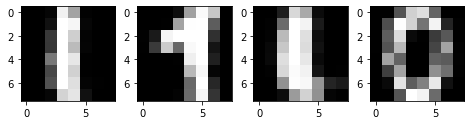

INFO:tensorflow:Assets written to: logs/GAN/20221120-125027/generator_network\assets
INFO:tensorflow:Assets written to: logs/GAN/20221120-125027/discriminator_network\assets
63000


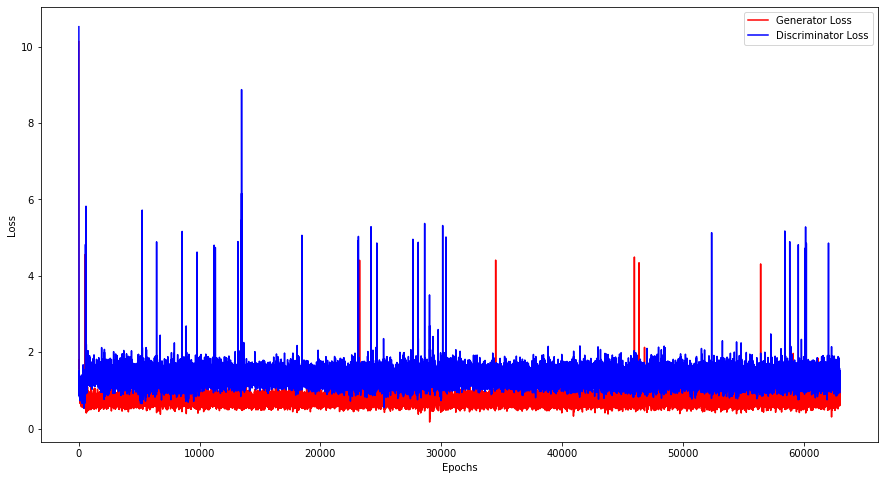

2022/11/20 13:54:53 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...


Saving models in mlflow...


2022/11/20 13:54:53 INFO mlflow.tensorflow: Validation succeeded!
2022/11/20 13:55:03 INFO mlflow.tensorflow: Validating the specified TensorFlow model by attempting to load it in a new TensorFlow graph...
2022/11/20 13:55:03 INFO mlflow.tensorflow: Validation succeeded!


In [28]:
# mlflow experiment settings
client = MlflowClient()
experiments = client.list_experiments()
experiment_name = 'Classical GAN'
#experiment_id = client.create_experiment(experiment_name)
#client.set_experiment_tag(experiment_id, 'GAN', 'GM')
print('Setting up experiment')
experiment = client.get_experiment_by_name(experiment_name)
experiment = mlflow.set_experiment(experiment_name=experiment_name)
experiment_id = experiment.experiment_id
run_name = 'Run'
i=0

with mlflow.start_run(run_name=run_name):
    # setting up generator and actor networks
    gen = generator(gen_init_layer_size = gen_init_layer_size, z_dim = z_dim)
    gen_net = gen.build_gen()
    disc = discriminator(disc_input_shape = disc_input_shape)
    disc_net = disc.build_disc()

    # starting mlflow run
    with mlflow.start_run(run_name=f'{run_name}_{i}', nested=True) as run:
        
        # training
        trainer = Trainer(x_train = train_dataset, gen_net = gen_net, disc_net = disc_net, gen_init_layer_size = gen_init_layer_size, z_dim = z_dim, 
                          disc_input_shape = disc_input_shape, batch_size = batch_size, writer = summary_writer, log_dir = log_dir)

        #%tensorboard --logdir logs/

        trainer.learn(epochs)
        
        # log and save the model in mlflow
        print('Saving models in mlflow...')
        models = ['generator_network', 'discriminator_network']
        artifact_path = f'mlruns/{experiment_id}/{run.info.run_id}/'
        for m in models:
            mlflow.tensorflow.save_model(tf_saved_model_dir = log_dir + m,
                                         tf_meta_graph_tags = None,
                                         tf_signature_def_key = "serving_default",
                                         path = artifact_path + "artifacts/" + m) 
    i+=1

### GIF

In [ ]:
# filepaths (fp)
fp_in = "/home/ludoboz/Projects/GAN & QGAN/logs/GAN/20221011-163716/image_at_epoch_*.png"
fp_out = "/home/ludoboz/Projects/GAN & QGAN/GAN.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=150, loop=0)

In [ ]:
plt.figure(figsize=(2, 2))

# all 0s
vector = np.array([[0 for _ in range(8)]])
# generate image
X = gen_net.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray')

plt.show()

In [ ]:
vector = np.array([[0 for _ in range(8)]])
vector

In [ ]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[11, :, :, 0], cmap='gray')

In [ ]:
x_train.shape

In [ ]:
#self.discriminator.compile(optimizer=self.disc_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#model_input = Input(shape=(self.z_dim,), name='model_input')
#model_output = self.discriminator(self.generator(model_input))
#self.model = Model(model_input, model_output)

#self.model.compile(optimizer=self.disc_opt , loss='binary_crossentropy', metrics=['accuracy'])   

#def adversarial_model(self):    
    #pass

#def train_generator(self):

#    valid = np.ones((self.batch_size,1))
#    noise = tf.random.normal(shape = (self.batch_size, self.z_dim), mean = 0, stddev = 1)

    #self.generator.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

#    return self.model.train_on_batch(noise, valid)


#def train_discriminator(self):

#    valid = np.ones((self.batch_size,1))
#    fake = np.zeros((self.batch_size,1))
    
    #self.discriminator.compile(optimizer=self.disc_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

#    for true_imgs in self.x_train:

#        a = tf.expand_dims(true_imgs, axis = 0)

    #true_imgs = next(self.x_train)[0]
    #if true_imgs.shape[0] != self.batch_size:
    #    true_imgs = next(self.x_train)[0]  
#        noise = tf.random.normal(shape = (self.batch_size, self.z_dim), mean = 0, stddev = 1)
#        gen_imgs = self.gen_net.predict(noise)     

#        disc_loss_real, disc_acc_real =  self.discriminator.train_on_batch(a, valid)
#        disc_loss_fake, disc_acc_fake =  self.discriminator.train_on_batch(gen_imgs, fake)
#        disc_loss =  0.5 * (disc_loss_real + disc_loss_fake)
#        disc_acc = 0.5 * (disc_acc_real + disc_acc_fake)

#    return [disc_loss, disc_loss_real, disc_loss_fake, disc_acc, disc_acc_real, disc_acc_fake]

#def train(self):

#    for epoch in range(self.epochs):
        
#        d = self.train_discriminator()
#        g = self.train_generator()

#        print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

#        self.d_loss.append(d[0])
#        self.g_loss.append(g)